In [3]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
from scipy.linalg import inv
import swyft

## Covariance estimate test

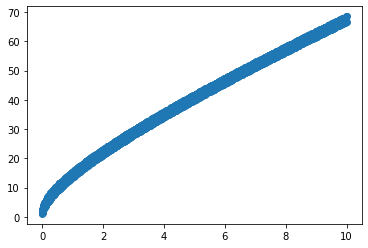

In [4]:
# Input data

N = 10000
slope = 3.5
sigma_a = 10.
sigma_b = 2.
a = torch.rand(N)*sigma_a
b = a*slope + torch.rand(N)*sigma_b + 10*a**0.5
plt.scatter(a, b)
#plt.plot(a, a*slope, 'r')

tensor(5.0136) tensor(39.6449) tensor(0.9958) tensor(6.0299) tensor(1.6095) tensor(1.6096)


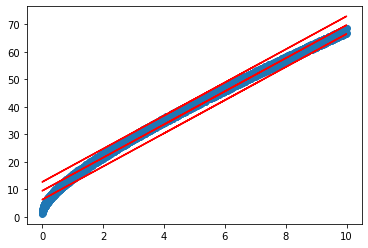

In [6]:
# Covariance and mean estimate
am = a.mean()
bm = b.mean()
eta = 1e-10
S = torch.tensor([[((a-am)**2).mean()+eta, ((a-am)*(b-bm)).mean()], [((a-am)*(b-bm)).mean(), ((b-bm)**2).mean()+eta]])
rho = S[0,1]/(S[0,0]*S[1,1])**0.5

slope_est = S[0, 1]/S[0,0]
sigma_est1 = (S[1,1]-S[0,1]**2/S[0,0])**0.5
sigma_est2 = (b-slope_est*a).std()#*((N-1)/N)**0.5

print(am, bm, rho, slope_est, sigma_est1, sigma_est2)
plt.scatter(a, b)
plt.plot(a, bm + (a-am)*slope_est, 'r')
plt.plot(a, bm + (a-am)*slope_est+sigma_est1*2, 'r')
plt.plot(a, bm + (a-am)*slope_est-sigma_est2*2, 'r')

In [7]:
DEVICE='cuda'

In [8]:
NPIX = 50
SIGMA = 0.001

## Model & prior

In [9]:
B = np.random.randn(NPIX)*0
def model(v):
    return dict(x = v + B)

In [10]:
def noise(sim, v, sigma = SIGMA):
    sim['x'] = sim['x'] + np.random.randn(NPIX)*sigma
    return sim

In [11]:
low =  np.zeros(NPIX)
high = np.ones(NPIX)
prior = swyft.get_uniform_prior(low, high)

## Training data generation

In [12]:
sim = swyft.Simulator(model, NPIX, dict(x=(NPIX,)))

In [13]:
Ntrain = 2000

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 2015 new samples to simulator store.


## SWYFT analysis

### Custom component

In [110]:
class RatioEstimatorGaussian1d(torch.nn.Module):
    def __init__(self, momentum = 0.1):
        super().__init__()
        self.momentum = momentum        
        self.x_mean = None
        self.z_mean = None
        self.x_var = None
        self.z_var = None
        self.xz_cov = None
        
    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """2-dim Gaussian approximation to marginals and joint, assuming (B, N)."""
        if self.training:
            # Covariance estimates must be based on joined samples only
            # NOTE: This makes assumptions about the structure of mini batches during training (J, M, M, J, J, M, M, J, ...)
            # TODO: Change to (J, M, J, M, J, M, ...) in the future
            batch_size = len(x)
            idx = np.array([[i, i+3] for i in np.arange(0, batch_size, 4)]).flatten() 
            
            # Estimation w/o Bessel's correction, using simple MLE estimate (https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices)
            x_mean_batch = x[idx].mean(dim=0).detach()
            z_mean_batch = z[idx].mean(dim=0).detach()
            x_var_batch = ((x[idx]-x_mean_batch)**2).mean(dim=0).detach()
            z_var_batch = ((z[idx]-z_mean_batch)**2).mean(dim=0).detach()
            xz_cov_batch = ((x[idx]-x_mean_batch)*(z[idx]-z_mean_batch)).mean(dim=0).detach()
            
            # Momentum-based update rule
            momentum = self.momentum
            self.x_mean = x_mean_batch if self.x_mean is None else (1-momentum)*self.x_mean + momentum*x_mean_batch
            self.x_var = x_var_batch if self.x_var is None else (1-momentum)*self.x_var + momentum*x_var_batch
            self.z_mean = z_mean_batch if self.z_mean is None else (1-momentum)*self.z_mean + momentum*z_mean_batch
            self.z_var = z_var_batch if self.z_var is None else (1-momentum)*self.z_var + momentum*z_var_batch
            self.xz_cov = xz_cov_batch if self.xz_cov is None else (1-momentum)*self.xz_cov + momentum*xz_cov_batch
            
        # log r(x, z) = log p(x, z)/p(x)/p(z), with covariance given by [[x_var, xz_cov], [xz_cov, z_var]]
        xb = (x-self.x_mean)/self.x_var**0.5
        zb = (z-self.z_mean)/self.z_var**0.5
        rho = self.xz_cov/self.x_var**0.5/self.z_var**0.5
        r = -0.5*torch.log(1-rho**2) + rho/(1-rho**2)*xb*zb - 0.5*rho**2/(1-rho**2)*(xb**2 + zb**2)
        out = torch.cat([r.unsqueeze(-1), z.unsqueeze(-1).detach()], dim=-1)
        return out

### Train and dataset

In [111]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

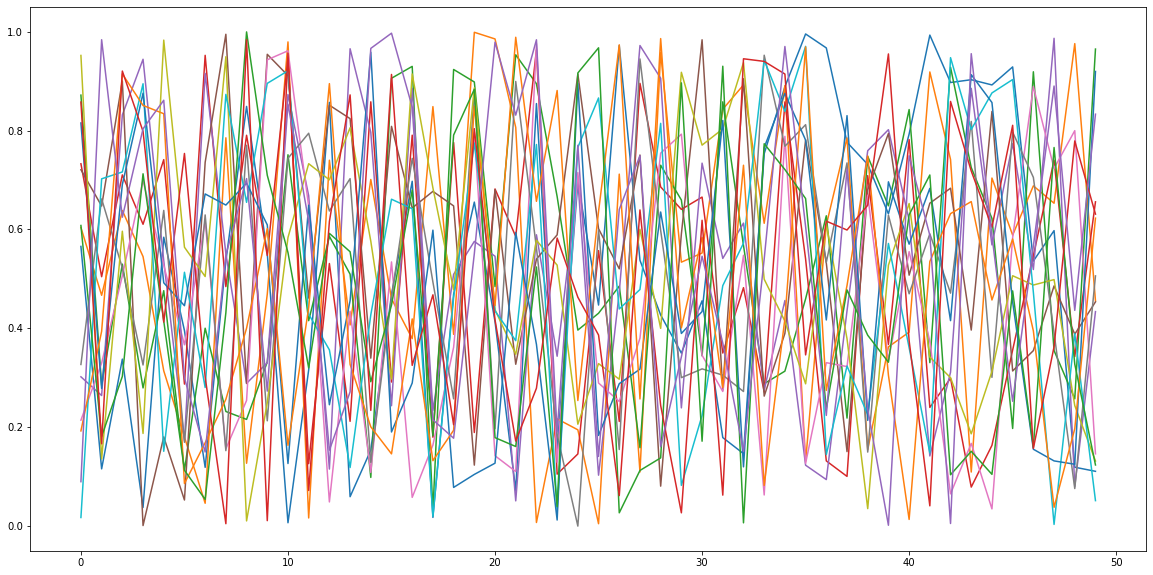

In [112]:
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.plot(dataset[i][0]['x'])

### Custom networks (taken from Elias)

In [113]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = None

    def forward(self, obs: dict) -> torch.Tensor:      
        x = obs['x']  # Needs to be replaced with estimating the src from images
        return x

class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self, momentum = 0.1):
        super().__init__()
        self.n_features = None
  
        self.Lz1 = swyft.networks.LinearWithChannel(NPIX, 1, 64)
        self.Lz2 = swyft.networks.LinearWithChannel(NPIX, 64, 64)
        self.Lz3 = swyft.networks.LinearWithChannel(NPIX, 64, 1)
        
        self.reg1d = RatioEstimatorGaussian1d(momentum = 0.1)
        
    def nonlinear(self, z):
        zz = self.Lz1(z.unsqueeze(-1))
        zz = torch.relu(zz)
        zz = self.Lz2(zz)
        zz = torch.relu(zz)
        return self.Lz3(zz).squeeze(-1)
                
    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """Gaussian approximation to marginals and joint."""
        z = z**2
        z = self.nonlinear(z)+z
        
        r = self.reg1d(x, z)  # Returns (B, M, 2)
        
        return r[..., 0]

class CustomParameterTransform(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, v):
        return v

In [114]:
observation_transform = CustomObservationTransform()
parameter_transform = CustomParameterTransform()
marginal_classifier = CustomMarginalClassifier()

In [115]:
network_1d = swyft.networks.Network(observation_transform, parameter_transform, marginal_classifier)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=[(1,), (2,)],
    network=network_1d,
    device=DEVICE,
)

### Training

In [116]:
opt =  torch.optim.Adam

In [117]:
vl = mre_1d.train(dataset, batch_size = 128, max_epochs = 100, learning_rate = 1e-2, optimizer = opt)

training: lr=0.01, epoch=6, validation loss=20.47

KeyboardInterrupt: 

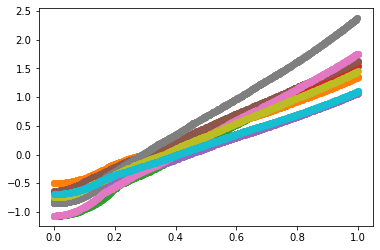

In [45]:
z = torch.rand(1000, NPIX).cuda().detach()
zz = marginal_classifier.nonlinear(z**2).detach()
for i in range(10):
    plt.scatter(z[:,i].cpu(), zz[:,i].cpu()+(z**2)[:,i].cpu())

### Results

In [46]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

In [58]:
obs0, _, v0 = dataset[1]
samples_1d = posterior_1d.weighted_sample(10000, obs0)
samples_1d.v.shape

(10000, 50)

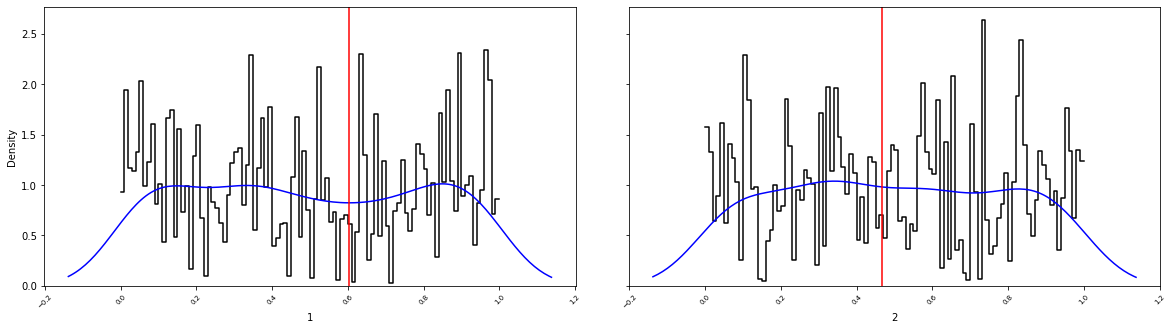

In [53]:
swyft.hist1d(samples_1d, kde = True, figsize = (20, 5), truth = v0);